Aquí se juntarán todos los csvs generados previamente, se llevará a cabo una limpieza y como resultado se espera un csv limpio con todos los datos

In [90]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Juntando todos los archivos en uno solo que se llama AllData.csv

In [91]:
directory_path = '../../data/excel'

# Encontrar todos los archivos CSV en el directorio
csv_files = [file for file in os.listdir(directory_path) if file.endswith('Data.csv')]

# Lista para guardar los datos de todos los archivos CSV
all_data_frames = []

# Leer cada archivo CSV y agregarlo a la lista
for csv_file in csv_files:
    file_path = os.path.join(directory_path, csv_file)
    data_frame = pd.read_csv(file_path)
    all_data_frames.append(data_frame)

# Combinar todos los DataFrames en uno solo
all_data_combined = pd.concat(all_data_frames, ignore_index=True)

# Guardar el DataFrame combinado en un nuevo archivo CSV
combined_csv_path = os.path.join(directory_path, 'AllData.csv')
all_data_combined.to_csv(combined_csv_path, index=False)

print(f'Todos los archivos han sido combinados y guardados en {combined_csv_path}')


FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: '../../data/excel'

Limpieza

In [ ]:
# Cargamos el archivo CSV en un DataFrame de pandas
# Reemplaza 'path_to_your_csv.csv' con la ruta real al archivo CSV que deseas analizar
csv_path = '../data/excel/AllData.csv'
df = pd.read_csv(csv_path)

# Contamos el número de filas donde la columna 'Total Energy (Ry)' tiene valores nulos o vacíos
missing_energy_count = df['Total Energy (Ry)'].isnull().sum()
print(f"Numero de renglones sin 'Total Energy': {missing_energy_count}")

Numero de renglones sin 'Total Energy': 44


Eliminando los datos que no tienen energía total

In [ ]:
# Eliminamos las filas donde 'Total Energy (Ry)' es nulo o vacío
df = df.dropna(subset=['Total Energy (Ry)'])

In [ ]:
missing_energy_count = df['Total Energy (Ry)'].isnull().sum()
print(f"Numero de renglones sin 'Total Energy': {missing_energy_count}")

Numero de renglones sin 'Total Energy': 0


In [ ]:
# Eliminar la columna 'Archivo'
cleanDF = df.drop('Archivo', axis=1)

Convirtiendo Total energy a float

In [ ]:
# Convert 'Total Energy (Ry)' to float
cleanDF['Total Energy (Ry)'] = pd.to_numeric(cleanDF['Total Energy (Ry)'], errors='coerce')

In [ ]:
# Drop any rows that could not be converted to float (e.g., containing non-numeric strings)
cleanDF = cleanDF.dropna(subset=['Total Energy (Ry)'])

In [ ]:
cleanDF.dtypes

Elemento              object
Ecut                   int64
KPoints               object
Pseudopotencial       object
Total Energy (Ry)    float64
dtype: object

Especificando que columnas de entrada son de que tipo

In [ ]:
# Selecting the numerical and categorical columns
numerical_cols = ['Ecut']  # the numerical column
categorical_cols = cleanDF.columns.drop(['Ecut', 'Total Energy (Ry)'])  # all   other columns are categorical

Tipo de Scaler que se usará para cada columna

In [ ]:
# Creating transformers for the numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

Muy buena herramienta porque transforma diferentes columnas dependiendo la necesidad de cada uno

In [ ]:
# Creating a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# Re-setup preprocessing and transformation
# Assume preprocessor is already defined and includes scaling for 'ecut' and one-hot encoding for categorical columns
X = cleanDF.drop('Total Energy (Ry)', axis=1)
y = cleanDF['Total Energy (Ry)']

In [ ]:
X_transformed = preprocessor.fit_transform(X)  # Re-fit the preprocessor

In [ ]:
# Create a preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

Dividiendo dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [ ]:
# Convert data types to float32 for neural network processing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

OneHotEncoder se usa para pasar a numeros las columnas string. Crea una columna nueva para cada string nuevo, por eso hay tantas columnas de input

In [ ]:
# Model configuration
input_dim = X_train.shape[1]  # Number of features
print(f'Columnas de input: {input_dim}')

Columnas de input: 46


Arquitectura de la red

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),  # First hidden layer
    Dense(64, activation='relu'), 
    Dense(1, activation='linear')  # Output layer
])

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Intentando con la función

In [95]:
from keras.callbacks import EarlyStopping
import random
import datetime

def train_until_mae_below_threshold_enhanced(X_train, y_train, X_test, y_test, initial_config, threshold=0.05):
    # Initialize training parameters
    config = initial_config.copy()
    best_mae = float('inf')  # Track best MAE
    log_path = "training_log.txt"

    # Open the log file
    with open(log_path, "w") as log_file:
        log_file.write("Training Start Time: {}\n".format(datetime.datetime.now()))
        
        # Possible activation functions to cycle through
        activations = ['relu', 'sigmoid', 'relu']
        
        while True:
            # Create model with dynamic activations
            model = Sequential([
                Dense(config['neurons'][0], activation=activations[0], input_shape=(X_train.shape[1],)),
                Dense(config['neurons'][1], activation=activations[1]),
                Dense(1, activation='linear')
            ])
            model.compile(optimizer='adam', loss='mean_absolute_error')
            
            # Early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            
            # Fit model
            history = model.fit(X_train, y_train, epochs=100, batch_size=config['batch_size'], validation_split=config['val_split'], verbose=0, callbacks=[early_stopping])
            
            # Predict and evaluate
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred)
            log_file.write("Config: {}, MAE: {}\n".format(config, mae))
            
            if mae < best_mae:
                best_mae = mae
                best_model_path = "best_model.h5"
                model.save(best_model_path)
                print('NEW BEST MODEL SAVED with mae:' + str(mae))
                log_file.write("New best model saved with MAE: {} at {}\n".format(best_mae, best_model_path))
            
            # Check if the MAE threshold is met
            if mae < threshold:
                break
            
            # Adjust parameters if needed
            # Cycle activations
            activations = activations[1:] + activations[:1]
            
            # Increase neurons
            config['neurons'] = [n + 8 for n in config['neurons']]
            
            # Adjust validation split
            config['val_split'] = random.uniform(0.2,0.01)
            
            # Adjust batch size
            config['batch_size'] = random.randint(10,33)

    return model, history


In [96]:
# Example usage:
initial_config = {
     'neurons': [32, 16],
     'val_split': 0.02,
     'batch_size': 32
 }
model, history = train_until_mae_below_threshold_enhanced(X_train, y_train, X_test, y_test, initial_config)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


NEW BEST MODEL SAVED with mae:181.74022


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


NEW BEST MODEL SAVED with mae:1.9510807


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


NEW BEST MODEL SAVED with mae:1.2786696


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


NEW BEST MODEL SAVED with mae:0.66799223


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


NEW BEST MODEL SAVED with mae:0.41078788


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

Tipo de compilación

In [ ]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.02, verbose=1)

Epoch 1/100


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 251.5390 - val_loss: 101.3258
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 96.4237 - val_loss: 40.6118
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 28.8908 - val_loss: 4.4121
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4115 - val_loss: 3.8885
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2434 - val_loss: 3.8853
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7807 - val_loss: 3.7542
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9126 - val_loss: 3.3928
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7211 - val_loss: 3.3150
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8448 - val_loss: 3.2161
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8758 - val_loss: 3.1420
Epoch 11/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3813 - val_loss: 3.4039
Epoch 12/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2

## Loss

In [ ]:
# Assuming history is returned by model.fit
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

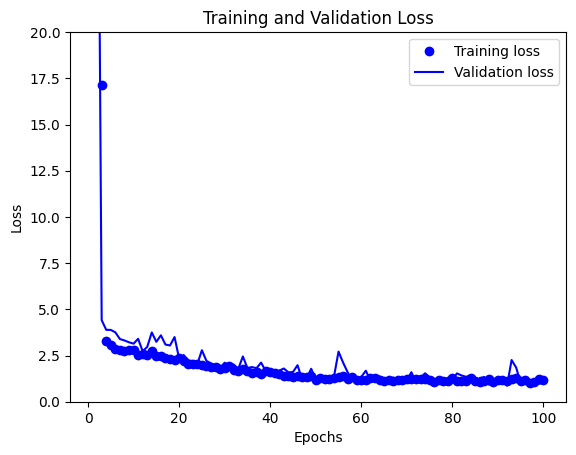

In [ ]:
# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' gives us blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' gives us a solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 20)
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9301 
Test Loss: 0.9160410165786743


R cuadrado (R2): un R² de 1,00 es perfecto.

Error cuadrático medio (MSE): un MSE de 0,81 indica que, en promedio, la diferencia al cuadrado entre los valores previstos y reales es menor que 1.

Error absoluto medio (MAE): un MAE de 0,61 sugiere que, en promedio la distancia hacia el objetivo.

Error cuadrático medio (RMSE): el valor RMSE de 0,90, que es la raíz cuadrada del MSE, suele ser más útil que el MSE para comprender el error promedio porque está en las mismas unidades que la variable objetivo. El hecho de que esté cerca del MAE sugiere que no hay muchos errores grandes que sesguen significativamente la media.

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the metrics
print(f'R-squared (R2): {r2:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R-squared (R2): 1.00
Mean Squared Error (MSE): 1.82
Mean Absolute Error (MAE): 0.92
Root Mean Squared Error (RMSE): 1.35


Guardando el preprocessor y el modelo de la red

In [ ]:
dump(pipeline.named_steps['preprocessor'], 'preprocessor.joblib')
model.save('my_model2.h5')
dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']